In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = 14, 10  # increase the default image size 

import skrf as rf # scikit-rf : object-oriented approach to microwave engineering

Populating the interactive namespace from numpy and matplotlib




In [2]:
# Importing home-made classes.
from icrh.antenna.conjugate_t import ConjugateT
from icrh.antenna.resonant_loop import ResonantDoubleLoop
from icrh.antenna.topica import TopicaResult

# Importing the full-wave solutions

We import the three devices of our electric circuit: the bridge, the impedance transformer and the window. As the default frequency range defined in skrf is the GHz, we set the frequency unit to MHz (this is only in order to have nicer plot after).  

In [3]:
bridge = rf.io.hfss_touchstone_2_network('../icrh/data/Sparameters/WEST/WEST_ICRH_bridge.s3p', f_unit='MHz')
impedance_transformer = rf.io.hfss_touchstone_2_network('../icrh/data/Sparameters/WEST/WEST_ICRH_impedance-transformer.s2p', f_unit='MHz')
window = rf.io.hfss_touchstone_2_network('../icrh/data/Sparameters/WEST/WEST_ICRH_window.s2p', f_unit='MHz')

# Single Resonant Loop

Here we create a single resonant loop, and match it on a manually created plasma.

In [4]:
CT1 = ConjugateT(bridge, impedance_transformer, window)
CT1.get_network() # look at the port char impedance to see if everything is fine

3-Port Network: 'WEST_ICRH_window',  40-60 MHz, 201 pts, z0=[ 29.73896504+0.j          13.68468209-0.00334742j  13.68647445-0.0033458j ]

Set the capacitors to dummy values and plot the S11 on a loading complex impedance for example.

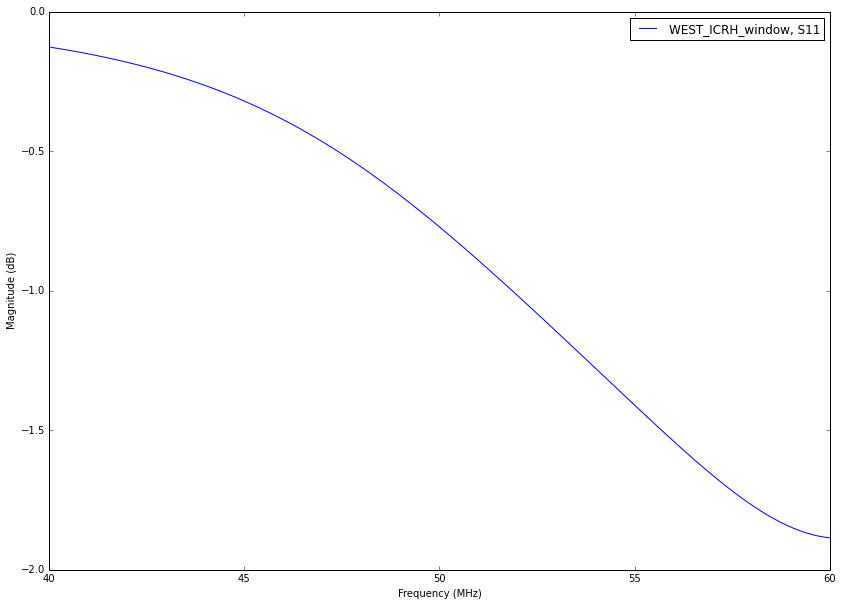

In [5]:
CT1.C = [60e-12, 60e-12]
CT1.load(1+30*1j).plot_s_db()

## Matching the single resonant loop

In [6]:
sol_single_CT = CT1.match(f_match=48e6, z_load=1+30*1j)

True [ 91.54057649  79.65443937]


Load the bridge with the capacitor values found:

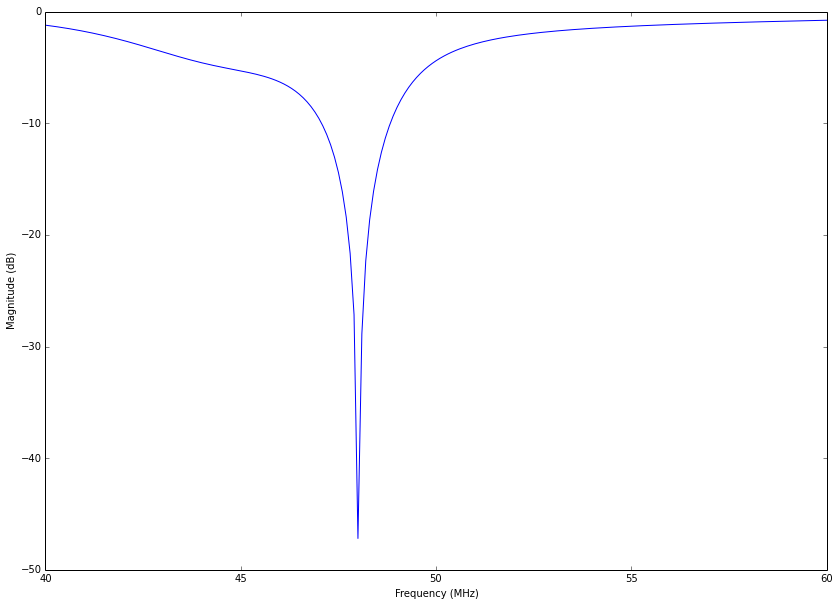

In [7]:
CT1.C = sol_single_CT.x
CT1.load(1+30*1j).plot_s_db(show_legend=False)

# Resonant Double Loop

We assume here that the bridge, impedance transformer and window are the same for both resonant loop.

In [8]:
RL1 = ConjugateT(bridge, impedance_transformer, window, name='RL1')
RL2 = ConjugateT(bridge, impedance_transformer, window, name='RL2')
RL1.get_network() # port 0 is 30 Ohm input, ports 1 & 2 bridge outputs

3-Port Network: 'WEST_ICRH_window',  40-60 MHz, 201 pts, z0=[ 29.73896504+0.j          13.68468209-0.00334742j  13.68647445-0.0033458j ]

Let's create an antenna with uncoupled staps (in poloidal and toroidal)

In [9]:
Z_simple1 = 1+30*1j
Z_simple2 = 1+30*1j
# The Z matrix ports indexing follows TOPICA convention, that is indexes strap 1 and 3, and 2 and 4
# create a diagonal Z-matrix
Z_matrix_simple = np.diag([Z_simple1, Z_simple2, Z_simple1, Z_simple2])

# creating the associated network
plasma = rf.Network(s=rf.z2s(np.tile(Z_matrix_simple,(len(bridge.frequency),1,1)), z0=[13,13,13,13]))
plasma.frequency = bridge.frequency
plasma.z0 = [13.7,13.7,13.7,13.7]
plasma

4-Port Network: '',  40-60 MHz, 201 pts, z0=[ 13.7+0.j  13.7+0.j  13.7+0.j  13.7+0.j]

Creating a resonant double loop antenna loaded with the above plasma.

In [10]:
RDL = ResonantDoubleLoop(RL1, RL2, plasma)

Set the capacitors of the antenna do dummy values and plot the Sii for example.

C:\Linux\scikit-rf\skrf\mathFunctions.py:164: RuntimeWarning: divide by zero encountered in log10
  out = 20 * npy.log10(input)


2-Port Network: 'antenna',  40-60 MHz, 201 pts, z0=[ 29.73896504+0.j  29.73896504+0.j]

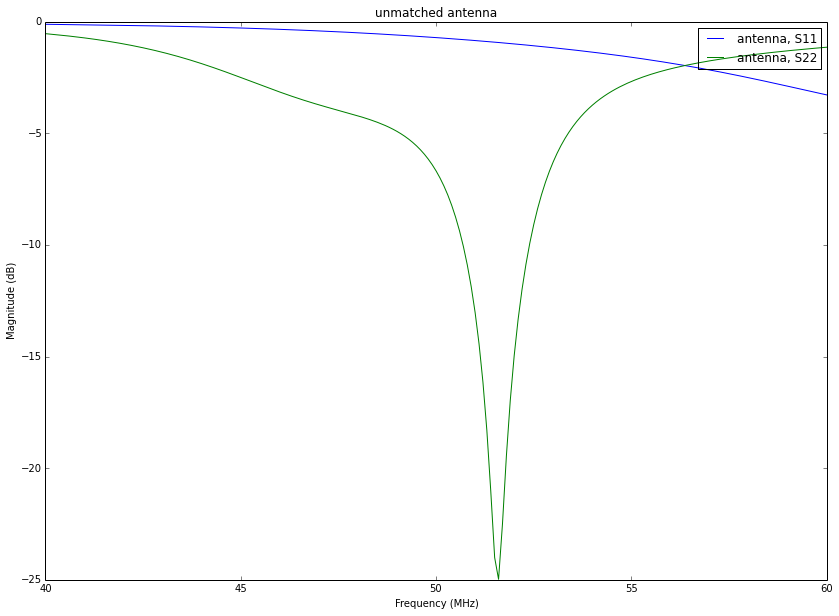

In [11]:
RDL.C = [50e-12, 60e-12, 70e-12, 80e-12]
antenna = RDL.get_network()
antenna.plot_s_db(m=0, n=0)
antenna.plot_s_db(m=1, n=1)
title('unmatched antenna')
antenna

## Matching the resonant double loop antenna

In [12]:
f_match = 48e6
Z_match = [30 + 1j*0, 30 + 1j*0]
power_in = [1, 1] # in Watts
phase_in = [0, pi] # in radians

sol_simple = RDL.match(power_in, phase_in, f_match, Z_match)

False [  7.66160156e+01   8.78437326e+01  -2.28614117e+06   7.82093185e+01]
Bad solution found (out of range capacitor) ! Re-doing...
True [ 87.84600752  76.60957193  76.61602025  87.84372533]
Solution found : C=[ 87.84600752  76.60957193  76.61602025  87.84372533]


C:\Program Files\WinPython\python-3.3.5.amd64\lib\site-packages\scipy\optimize\minpack.py:236: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Test how good is the solution that has been found. 

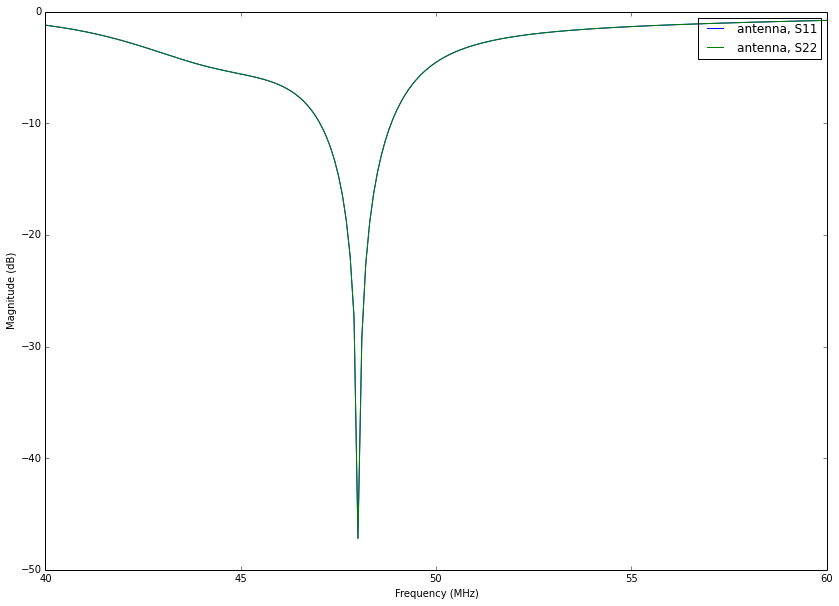

In [13]:
RDL.C = sol_simple.x
antenna = RDL.get_network()
antenna.plot_s_db(m=0,n=0)
antenna.plot_s_db(m=1,n=1)


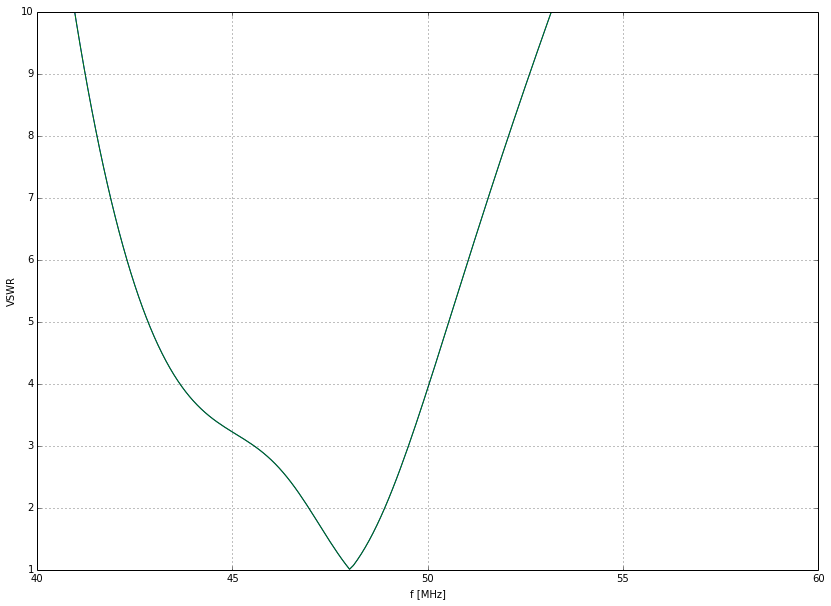

In [14]:
plot(RDL.get_f()/1e6, RDL.get_vswr_active(power_in, phase_in))
grid()
axis([40, 60, 1, 10])
xlabel('f [MHz]')
ylabel('VSWR')

# TOPICA Matrix

Here we connect a TOPICA coupling matrix to two resonant loops. Pay attention to the way TOPICA indexes the straps. 
$$\begin{matrix}
2 & | & 1 \\
4 & | & 3
\end{matrix}$$
cf figure below
![](figures/network.png)

In [42]:
def TOPICA_plasma(s4p_filename):
    '''
    Returns a skrf Network from a Touchstone file which contains TOPICA plasma simulation.
    
    The S-parameters are repeated for all frequencies for compatibility with skrf.
    '''
    plasma_TOPICA = rf.io.hfss_touchstone_2_network(s4p_filename)
    plasma_TOPICA.frequency = bridge.frequency
    plasma_TOPICA.s = np.tile(plasma_TOPICA.s, (len(plasma.frequency), 1, 1))
    plasma_TOPICA.z0 = np.tile(plasma_TOPICA.z0, (len(plasma.frequency),1))
    return plasma_TOPICA

In [38]:
plasma_TOPICA = TOPICA_plasma('../icrh/data/Sparameters/WEST/plasma_from_TOPICA/S_TSproto12_55MHz_Profile8.s4p')
print(plasma_TOPICA)
print(bridge)

4-Port Network: 'S_TSproto12_55MHz_Profile8',  40-60 MHz, 201 pts, z0=[ 46.7+0.j  46.7+0.j  46.7+0.j  46.7+0.j]
3-Port Network: 'WEST_ICRH_bridge',  40-60 MHz, 201 pts, z0=[  5.68450244-0.00430942j  13.68468209-0.00334742j  13.68647445-0.0033458j ]


In [39]:
f_match = 55e6
Z_match = [30+1j*0, 30+1j*0]
power_in = [1, 1]
phase_in = [0, pi]

In [40]:
CT1 = ConjugateT(bridge, impedance_transformer, window)
CT2 = ConjugateT(bridge, impedance_transformer, window)

RDL = ResonantDoubleLoop(CT1, CT2, plasma_TOPICA)

sol_TOPICA = RDL.match(power_in, phase_in, f_match, Z_match)

False [    67.08264083  25346.04118497     66.85038969     89.20569381]
Bad solution found (out of range capacitor) ! Re-doing...
True [ 65.42389272  83.62727707  65.48500699  84.93378683]
Solution found : C=[ 65.42389272  83.62727707  65.48500699  84.93378683]


C:\Program Files\WinPython\python-3.3.5.amd64\lib\site-packages\scipy\optimize\minpack.py:236: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


For the same set of capacitor values found, we vary the plasma load and plot scattering parameters and VSWR

[40, 60, -50, 0]

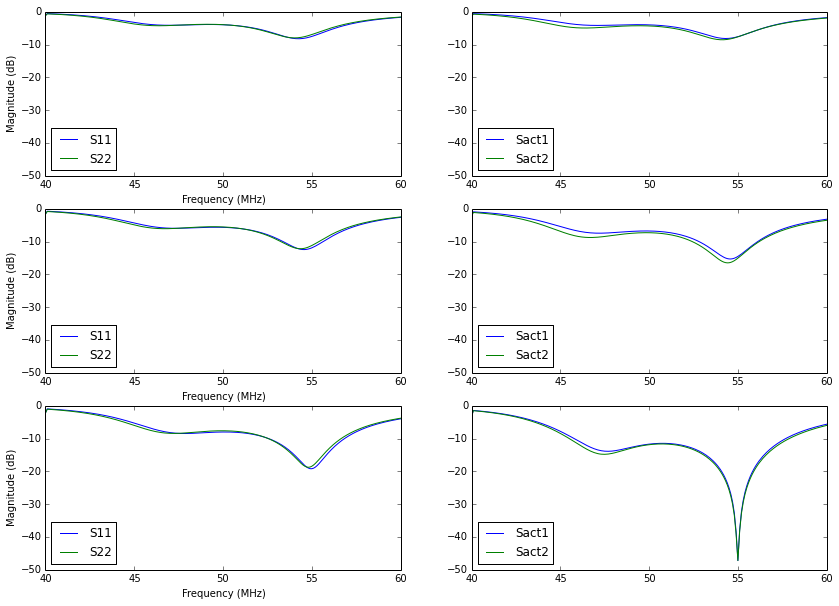

In [43]:
RDL.plasma = TOPICA_plasma('../icrh/data/Sparameters/WEST/plasma_from_TOPICA/S_TSproto12_55MHz_Profile1.s4p')

subplot(321)
RDL.get_network().plot_s_db(m=0,n=0)
RDL.get_network().plot_s_db(m=1,n=1)
axis([40,60,-50,0])
legend(('S11', 'S22'),loc='best')
subplot(322)
plot(RDL.get_f()/1e6, 20*np.log10(np.abs(RDL.get_s_active(power_in, phase_in))))
legend(('Sact1', 'Sact2'),loc='best')
axis([40,60,-50,0])

RDL.plasma = TOPICA_plasma('../icrh/data/Sparameters/WEST/plasma_from_TOPICA/S_TSproto12_55MHz_Profile4.s4p')

subplot(323)
RDL.get_network().plot_s_db(m=0,n=0)
RDL.get_network().plot_s_db(m=1,n=1)
axis([40,60,-50,0])
legend(('S11', 'S22'),loc='best')
subplot(324)
plot(RDL.get_f()/1e6, 20*np.log10(np.abs(RDL.get_s_active(power_in, phase_in))))
legend(('Sact1', 'Sact2'),loc='best')
axis([40,60,-50,0])

RDL.plasma = TOPICA_plasma('../icrh/data/Sparameters/WEST/plasma_from_TOPICA/S_TSproto12_55MHz_Profile8.s4p')

subplot(325)
RDL.get_network().plot_s_db(m=0,n=0)
RDL.get_network().plot_s_db(m=1,n=1)
axis([40,60,-50,0])
legend(('S11', 'S22'),loc='best')
subplot(326)
plot(RDL.get_f()/1e6, 20*np.log10(np.abs(RDL.get_s_active(power_in, phase_in))))
legend(('Sact1', 'Sact2'),loc='best')
axis([40,60,-50,0])


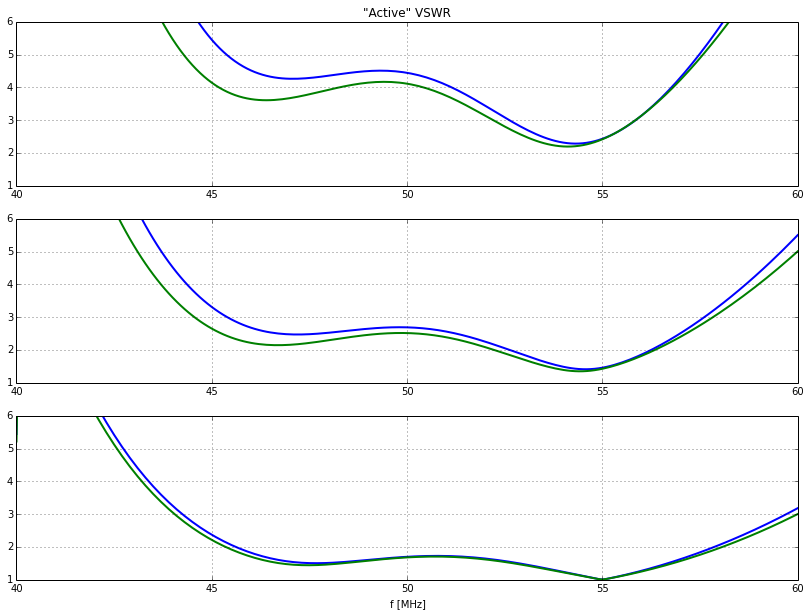

In [44]:
RDL.plasma = TOPICA_plasma('../icrh/data/Sparameters/WEST/plasma_from_TOPICA/S_TSproto12_55MHz_Profile1.s4p')

subplot(311)
plot(RDL.get_f()/1e6, RDL.get_vswr_active(power_in, phase_in), lw=2)
axis([40,60,1,6])
grid()
title('"Active" VSWR')

RDL.plasma = TOPICA_plasma('../icrh/data/Sparameters/WEST/plasma_from_TOPICA/S_TSproto12_55MHz_Profile4.s4p')

subplot(312)
plot(RDL.get_f()/1e6, RDL.get_vswr_active(power_in, phase_in), lw=2)
axis([40,60,1,6])
grid()

RDL.plasma = TOPICA_plasma('../icrh/data/Sparameters/WEST/plasma_from_TOPICA/S_TSproto12_55MHz_Profile8.s4p')

subplot(313)
plot(RDL.get_f()/1e6, RDL.get_vswr_active(power_in, phase_in), lw=2)
axis([40,60,1,6])
grid()
xlabel('f [MHz]')
